In [1]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import tensorflow.keras.backend as K
import tensorflow as tf

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.set_random_seed(seed)
from tensorflow.compat.v1 import ConfigProto,InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True 
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)
#tf.keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [2]:
from tensorflow.keras.models import load_model
model = load_model("../outputs/inception/inception")
#model.load_weights("../outputs/main_heatmap_weight.hdf5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [30]:
def get_last_conv_layer_info(model):
    last_conv_layer_name="conv2d"
    last_conv_filter = 0
    for ml in model.layers:
        #print ("{}, {} {}".format(ml.name, ml.output.get_shape(), ml.output.get_shape()[-1] ))
        if "conv2d_" in ml.name:
            last_conv_layer_name = ml.name
            last_conv_filter = ml.output.get_shape()[-1]
    return last_conv_layer_name, last_conv_filter
last_conv_layer_name, last_conv_filter = get_last_conv_layer_info(model)
LAST_CONV_NAME=last_conv_layer_name
LAST_CONV_SIZE=last_conv_filter
if LAST_CONV_SIZE < 1:
    print("ERROR: Last Covlution information not found. No heatmap will be generated")
else:
    print("Last Conv layer = ({}, {})".format(LAST_CONV_NAME, LAST_CONV_SIZE))

Last Conv layer = (conv2d_187, 192)


In [108]:
from skimage import data, color, io, img_as_float
from skimage import filters
def get_heatmap(processed_image, class_idx):
    # we want the activations for the predicted label
    class_output = model.output[:, class_idx]
    
    # choose the last conv layer in your model
    last_conv_layer = model.get_layer("mixed10")
    # get the gradients wrt to the last conv layer
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
   # we pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = K.mean(grads, axis=(0,1,2))
    print(pooled_grads)
    # Define a function that generates the values for the output and gradients
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = iterate([processed_image])
    
    # iterate over each feature map in your conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    nv = grads_values.shape[0]
    for i in range(nv):
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

In [109]:
def pre(sample_image,model):
    sample_image = cv2.resize(sample_image, (150,150))
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = sample_image.astype(np.float32)/255.
    sample_label = 1
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    pred_label =[]
    pred_label = model.predict(sample_image_processed)
    pred_label = list(pred_label[0]).index(max(pred_label[0]))
    return pred_label,sample_image,sample_image_processed

In [110]:
def heatm(pred_label,sample_image,sample_image_processed):
    # get the heatmap for class activation map(CAM)
    heatmap = get_heatmap(sample_image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    #superimpose the heatmap on the image    

    sample_image_hsv = color.rgb2hsv(sample_image)
    heatmap = color.rgb2hsv(heatmap)

    alpha=.9
    sample_image_hsv[..., 0] = heatmap[..., 0]
    sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

    img_masked = color.hsv2rgb(sample_image_hsv)
    return img_masked

In [113]:
from glob import glob #retriving an array of files in directories
path_test = "../proc_input/covid_data/test/"
dis = ["NORMAL","PNEUMONIA","COVID"]
num = 5

Tensor("Mean_94:0", shape=(2048,), dtype=float32)
Tensor("Mean_95:0", shape=(2048,), dtype=float32)
Tensor("Mean_96:0", shape=(2048,), dtype=float32)
Tensor("Mean_97:0", shape=(2048,), dtype=float32)
Tensor("Mean_98:0", shape=(2048,), dtype=float32)


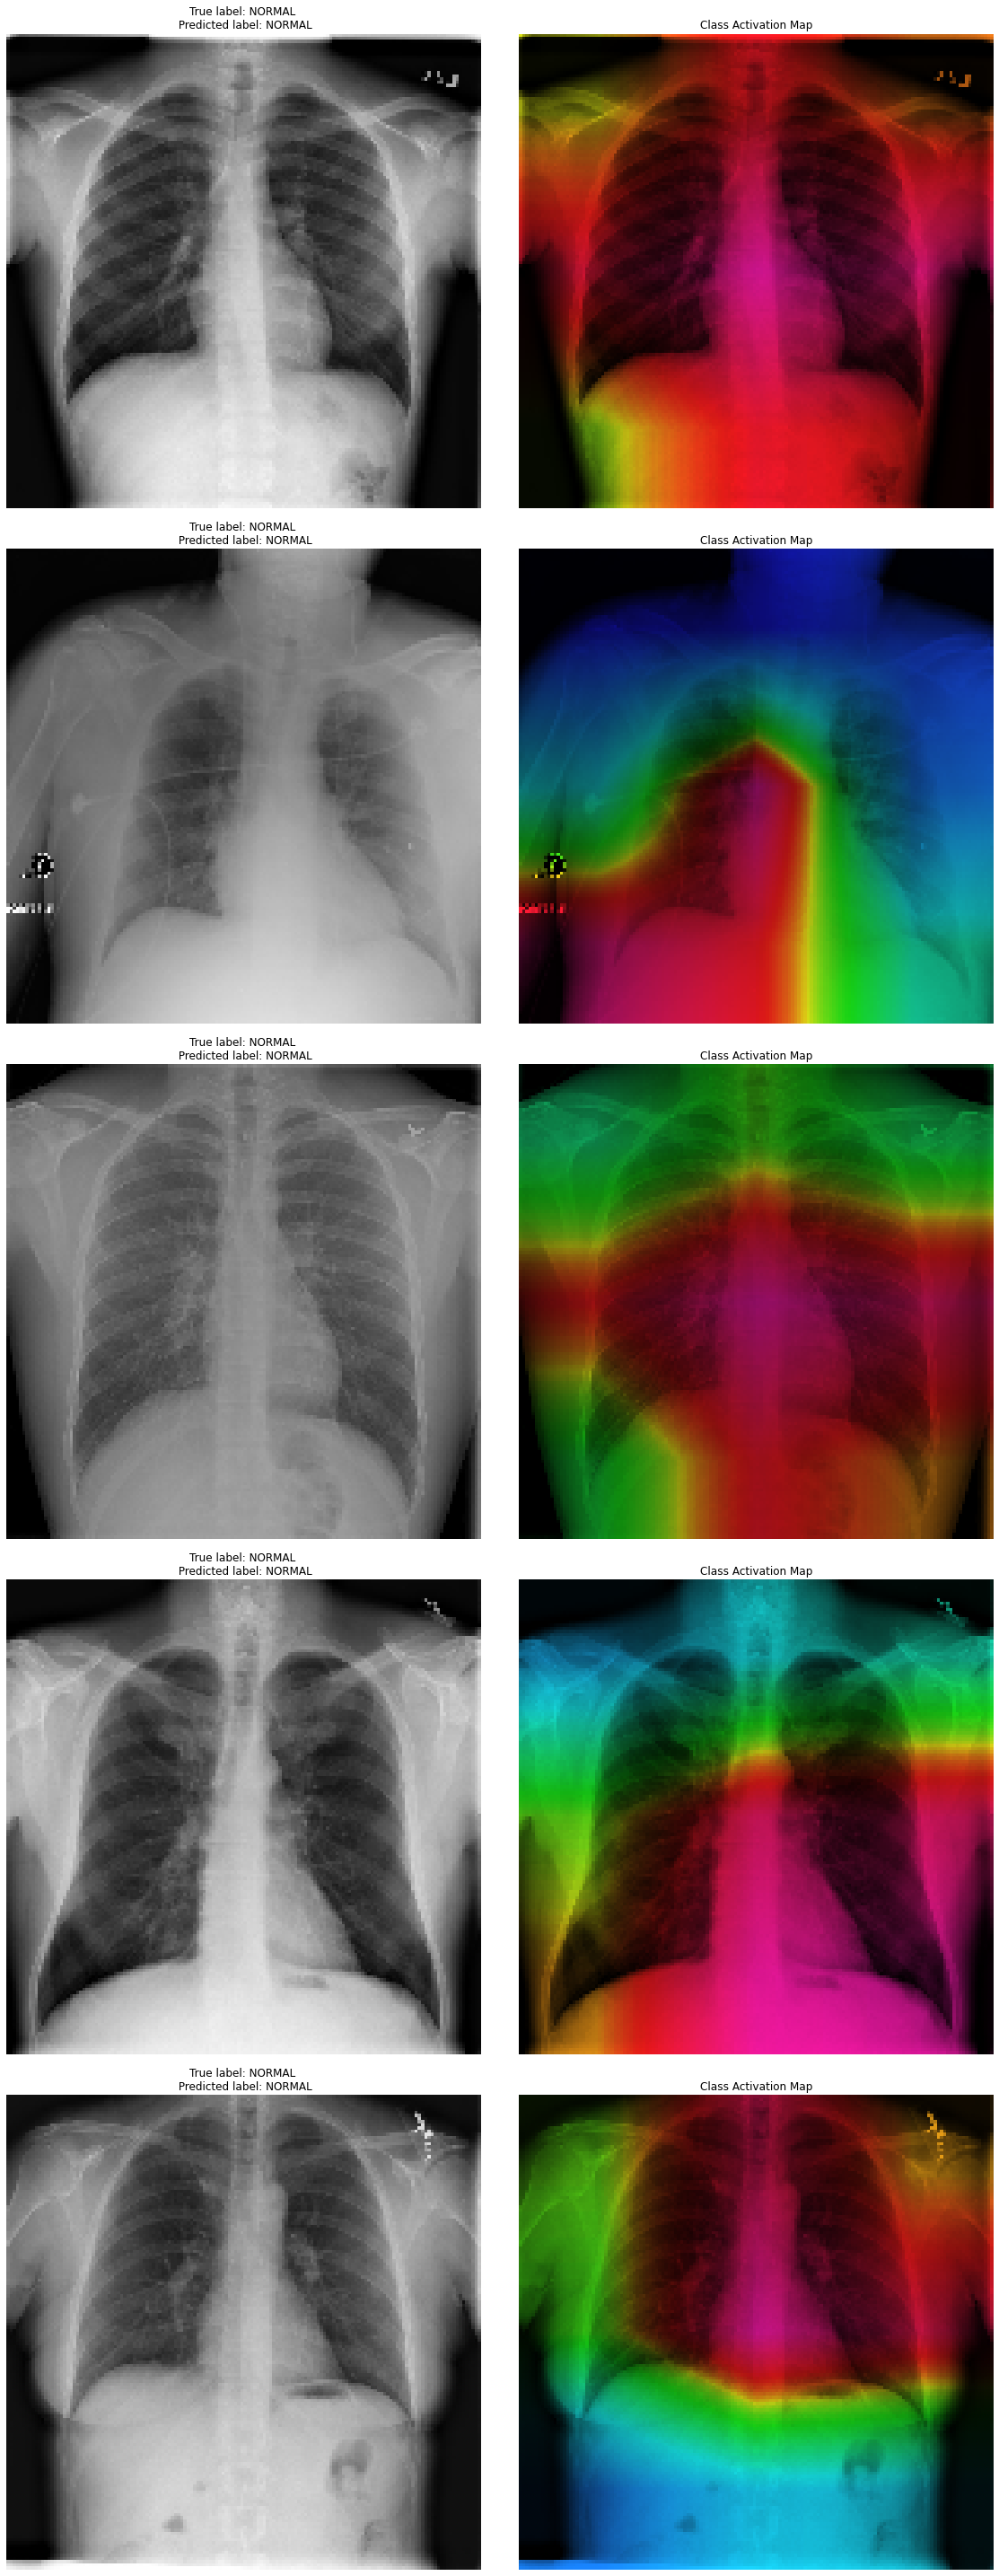

In [118]:
#NORMAL HEATMAP
img = glob(path_test+dis[0]+"/*.jpg")
random.shuffle(img)
f,ax = plt.subplots(num,2, figsize=(16,40))
ax = ax.ravel()
plt.tight_layout()
i = 0
for sample_image in (img[:num]):
    sample_image = plt.imread(sample_image)
    pred_label,sample_image1,sample_image_processed = pre(sample_image,model)
    img_masked = heatm(pred_label,sample_image1,sample_image_processed)
    ax[i].imshow(sample_image1)
    ax[i].set_title(f"True label: {dis[0]} \n Predicted label: {dis[pred_label]}")
    ax[i].axis('off')
    i+=1
    ax[i].imshow(img_masked)
    ax[i].set_title("Class Activation Map")
    ax[i].axis('off')
    i+=1
plt.show()

Tensor("Mean_99:0", shape=(2048,), dtype=float32)
Tensor("Mean_100:0", shape=(2048,), dtype=float32)
Tensor("Mean_101:0", shape=(2048,), dtype=float32)
Tensor("Mean_102:0", shape=(2048,), dtype=float32)
Tensor("Mean_103:0", shape=(2048,), dtype=float32)


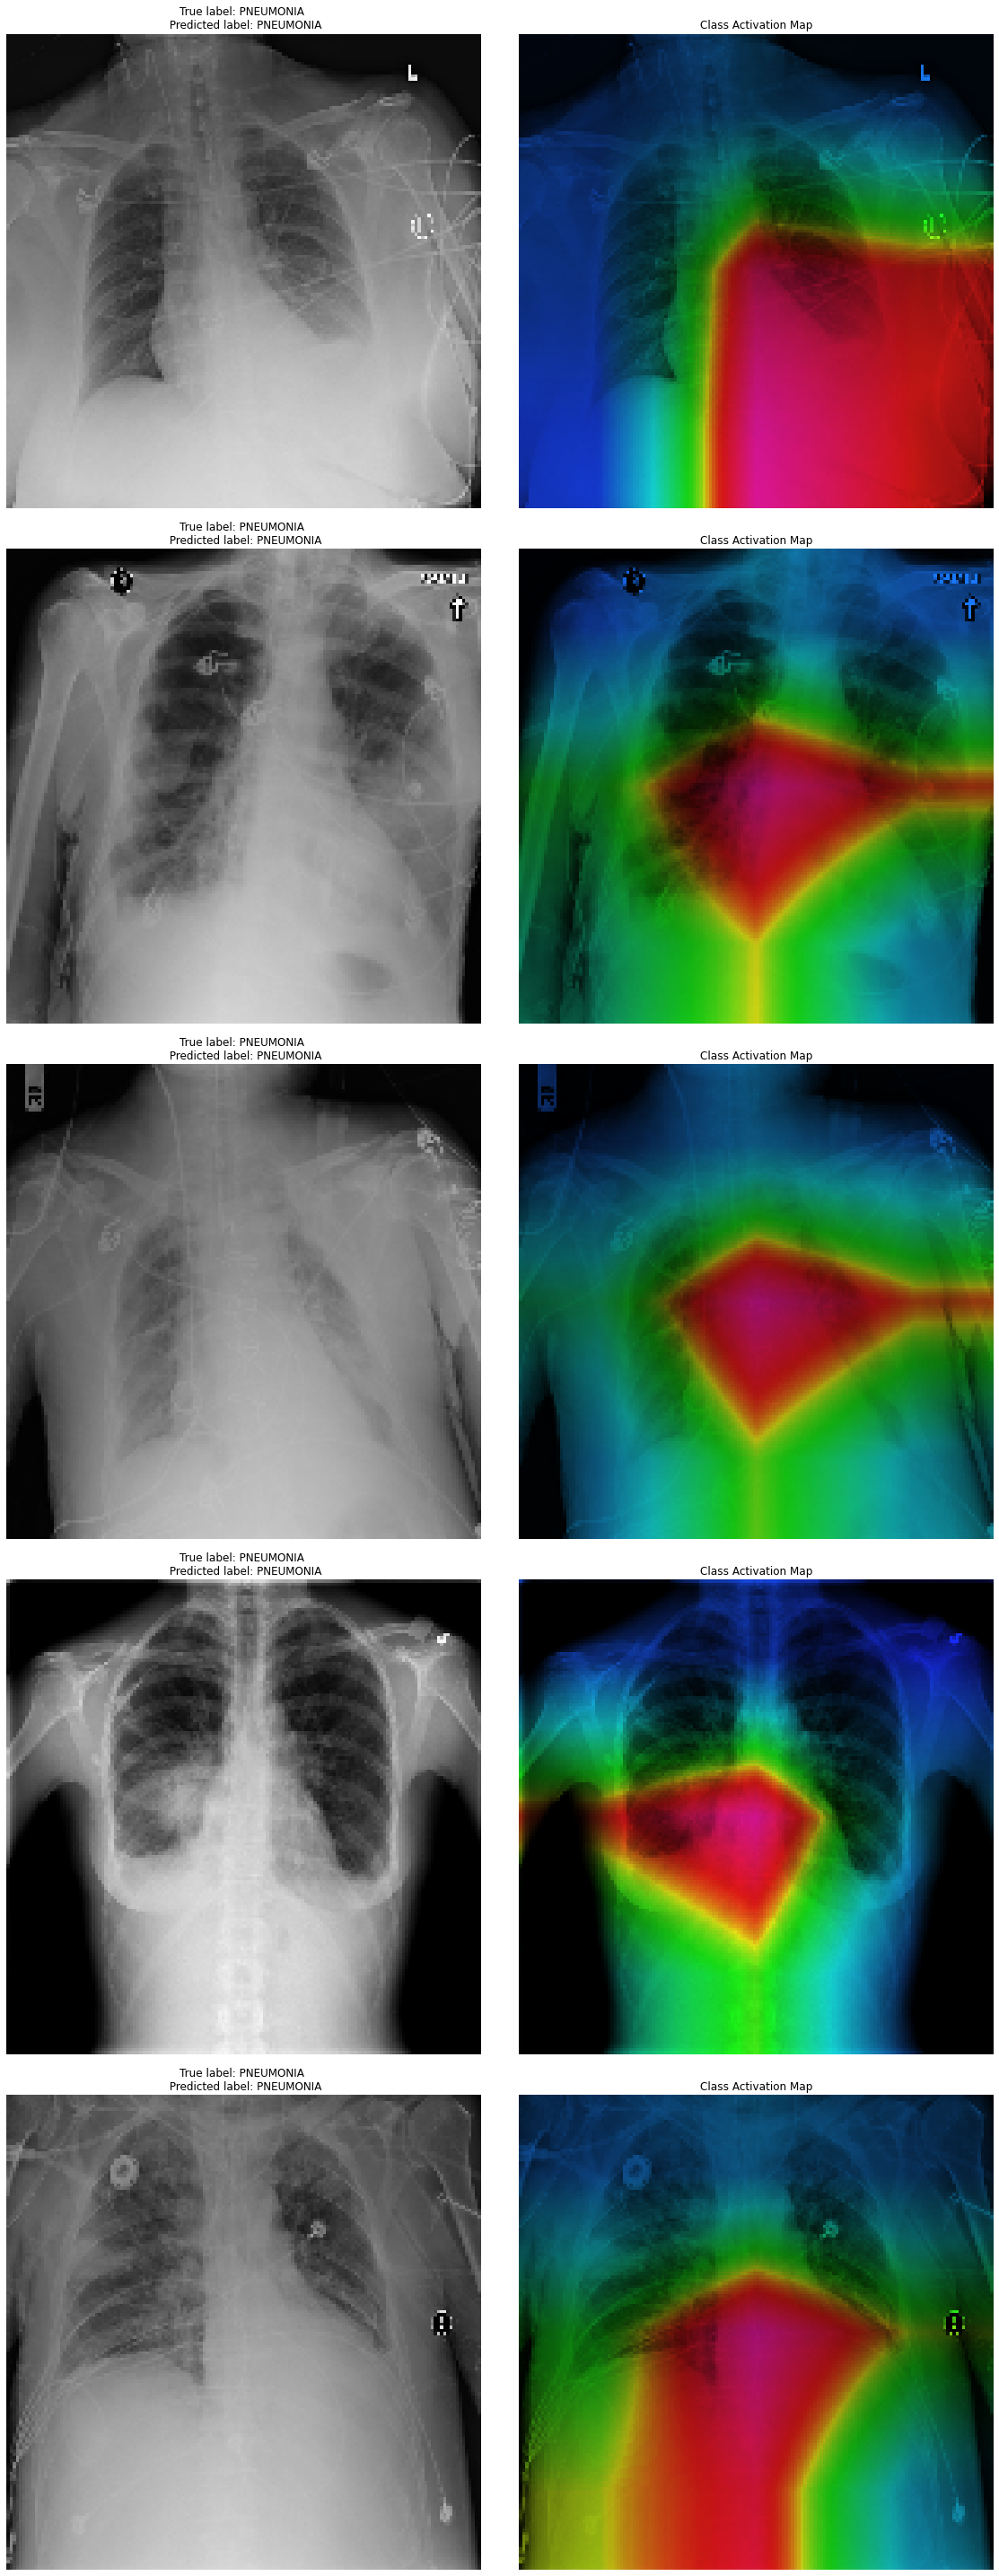

In [119]:
#PNEUMONIA HEATMAP
img = glob(path_test+dis[1]+"/*.jpg")
random.shuffle(img)
f,ax = plt.subplots(num,2, figsize=(16,40))
ax = ax.ravel()
plt.tight_layout()
i = 0
for sample_image in (img[:num]):
    sample_image = plt.imread(sample_image)
    pred_label,sample_image1,sample_image_processed = pre(sample_image,model)
    img_masked = heatm(pred_label,sample_image1,sample_image_processed)
    ax[i].imshow(sample_image1)
    ax[i].set_title(f"True label: {dis[1]} \n Predicted label: {dis[pred_label]}")
    ax[i].axis('off')
    i+=1
    ax[i].imshow(img_masked)
    ax[i].set_title("Class Activation Map")
    ax[i].axis('off')
    i+=1
plt.show()

Tensor("Mean_104:0", shape=(2048,), dtype=float32)
Tensor("Mean_105:0", shape=(2048,), dtype=float32)
Tensor("Mean_106:0", shape=(2048,), dtype=float32)
Tensor("Mean_107:0", shape=(2048,), dtype=float32)
Tensor("Mean_108:0", shape=(2048,), dtype=float32)


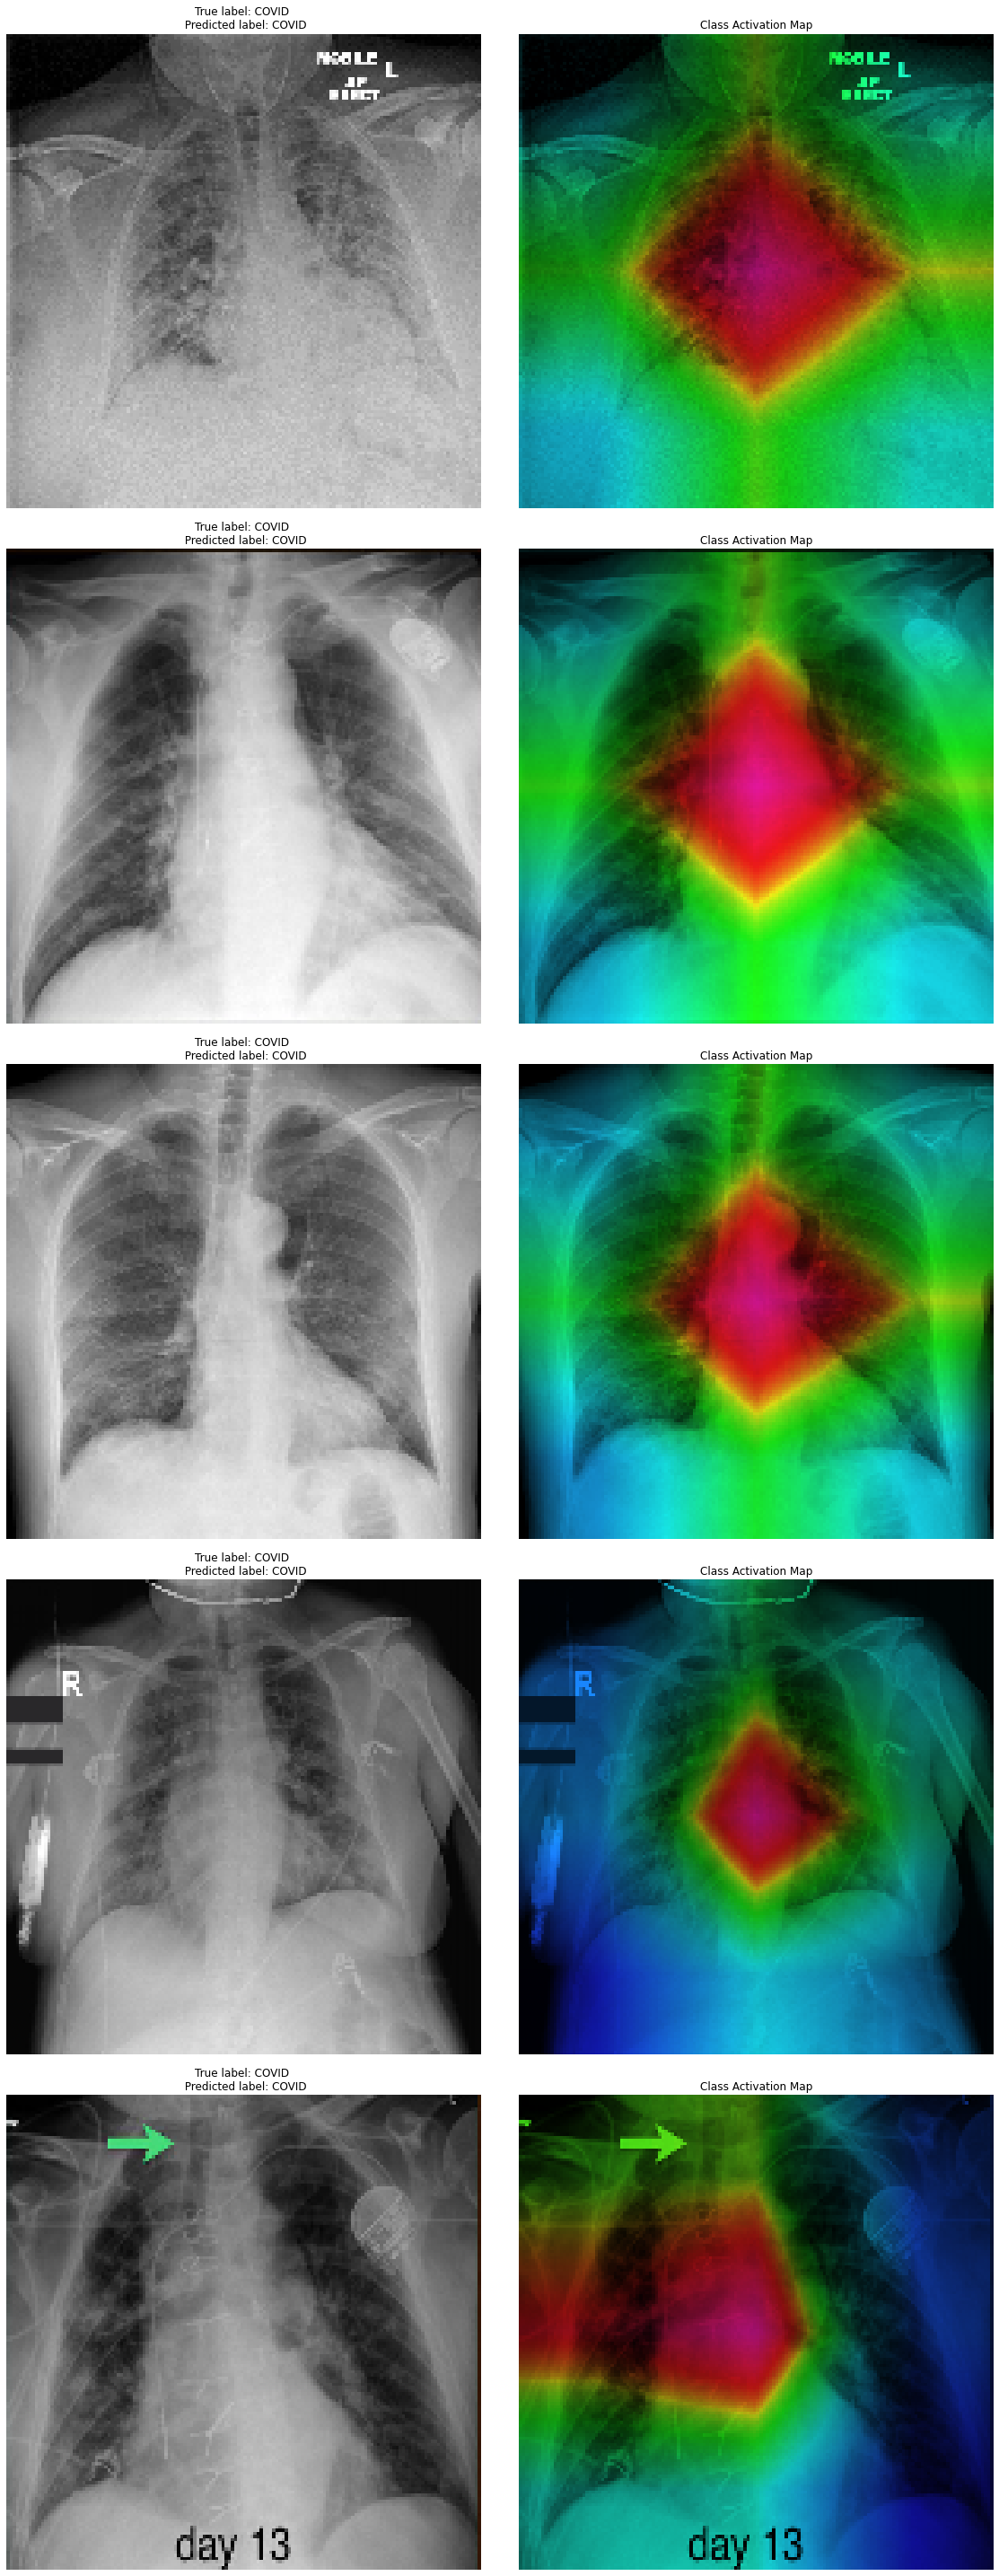

In [120]:
#COVID HEATMAP
img = glob(path_test+dis[2]+"/*.jpg")
random.shuffle(img)
f,ax = plt.subplots(num,2, figsize=(16,40))
ax = ax.ravel()
plt.tight_layout()
i = 0
for sample_image in (img[:num]):
    sample_image = plt.imread(sample_image)
    pred_label,sample_image1,sample_image_processed = pre(sample_image,model)
    img_masked = heatm(pred_label,sample_image1,sample_image_processed)
    ax[i].imshow(sample_image1)
    ax[i].set_title(f"True label: {dis[2]} \n Predicted label: {dis[pred_label]}")
    ax[i].axis('off')
    i+=1
    ax[i].imshow(img_masked)
    ax[i].set_title("Class Activation Map")
    ax[i].axis('off')
    i+=1
plt.show()